# Introduction

This notebook aims at discovering Convolutional Neural Network. We will see the theory behind it, and an implementation in Pytorch for hand-digits classification on MNIST dataset. 

# History

Contrary to what most people think, Neural Networks is quite an old concept. It was first introduced in 1957 under the name ***perceptron***. Peceptron is a 1-layer feed forward neural network. However the infrastructure and the algorthm around it was not good enough to allow large scale training. Later on in 1986, ***Multi Layer Perceptron (MLP)*** was introduced with the backpropagation algorithm in order to train a network with more than 1 layer. Thanks to this algorithm we are not able to train non-linear model which can learn high level abstract features. Then ***Convolutional Neural Network (CNN)*** has been introduced in order to learn better features and with the possibility to reduce the number of parameters to be trained. And now, here we are, in the ***Deep Learning era*** 

    # Multi-Layer Perceptron

The first thing to ask is : why do we needed Convolutional Neural Network in the first place... Well, let's see what happen when we train a Multi-Layer Perceptron to recognize hand-written digits. In Machine Learning we have our own "Hello World" which is the MNIST dataset. Let's see what this dataset is about and how a multi-layer perceptron will perform.   

In [59]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [60]:
data = np.load('Data/data_train.npy').T
X_og = data.copy()/255
y =np.loadtxt('Data/correct_labels.npy')

In [61]:
print(X_og)

[[0.63137255 0.63529412 0.63529412 ... 0.58431373 0.58431373 0.57647059]
 [0.63529412 0.63529412 0.63529412 ... 0.64705882 0.64705882 0.64705882]
 [0.76470588 0.76470588 0.76470588 ... 0.74901961 0.74901961 0.74901961]
 ...
 [0.76470588 0.76470588 0.76470588 ... 0.76470588 0.76470588 0.76470588]
 [0.61960784 0.61568627 0.61568627 ... 0.55294118 0.54901961 0.55294118]
 [0.58431373 0.58431373 0.58823529 ... 0.54117647 0.55686275 0.57647059]]


In [62]:
y = y.astype(float).astype(int)
print(y)

[8 8 1 ... 1 3 3]


In [63]:
print(np.shape(X_og))
print(np.shape(y))

(6720, 90000)
(6720,)


In [64]:
#X = 1-X_og.copy()
def resize_func(input_data,new_width,new_height):#input the (1,90000) data
    size1 = np.shape(input_data)[0]
    size2 = int(size1**(0.5))
    output = cv2.resize(input_data.reshape(size2,size2),(new_width,new_height))
    return output
def morph_ops(input_data):
    dilate_kernel = np.ones((2,2),np.uint8)
    x0 = 1-input_data
    x0_1 = resize_func(x0,50,50)
    x1 = x0_1.reshape(50,50)
    x4 = np.clip(x1-np.mean(x1),0,1)
    x5 = np.where(x1 < 0.35,0,x4)
    dilate_kernel = np.ones((2,2),np.uint8)
    x6 = cv2.dilate(x5,dilate_kernel,iterations=1)
    x7 = np.where(x6<0.15,0,x6)
    x8 = normalize(x7.reshape(-1,1)).reshape(50,50)
    x9 = np.where(x8>0.3,1,x8)
    x10 = x9.reshape(1,-1)
    picture = x10
    return picture


X_new = np.zeros((np.shape(X_og)[0],50*50))

for ii in range(np.shape(X_new)[0]):
    newrow = morph_ops(X_og[ii,:])
    newrow = newrow.reshape(1,-1)
    newrow = resize_func(newrow[0,:],50,50)
    newrow = newrow.reshape(1,-1)
    X_new[ii,:] = newrow
X = X_new

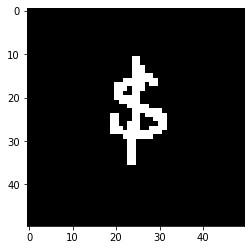

In [65]:
index = 0
x1 = X[index,:].reshape(50,50)
plt.imshow(x1,cmap='gray')

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [67]:
BATCH_SIZE = 200

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


In [68]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(50*50,500)
        self.linear2 = nn.Linear(500,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
 
mlp = MLP()
print(mlp)


MLP(
  (linear1): Linear(in_features=2500, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


We have 784\*(250+1) + 250\*(100+1) + 100\*(10+1) = 222 360 parameters to train

In [69]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)#,lr=0.001, betas=(0.9,0.999))
    error = nn.CrossEntropyLoss()
    EPOCHS = 250
    model.train()
    lossvec = []
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            lossvec.append(loss.item())
            optimizer.step()

            # Total correct predictions
            #predicted = torch.max(output.data,0)[1]
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            #print(correct)
            if batch_idx % 100 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
    return lossvec
                

In [70]:
loss_vec = fit(mlp, train_loader)

Epoch : 0 [0/5376 (0%)]	Loss: 2.308540	 Accuracy:11.500%
Epoch : 1 [0/5376 (0%)]	Loss: 1.550054	 Accuracy:50.000%
Epoch : 2 [0/5376 (0%)]	Loss: 1.245156	 Accuracy:61.500%
Epoch : 3 [0/5376 (0%)]	Loss: 0.990328	 Accuracy:71.000%
Epoch : 4 [0/5376 (0%)]	Loss: 0.767749	 Accuracy:78.000%
Epoch : 5 [0/5376 (0%)]	Loss: 0.575144	 Accuracy:85.000%
Epoch : 6 [0/5376 (0%)]	Loss: 0.471227	 Accuracy:86.500%
Epoch : 7 [0/5376 (0%)]	Loss: 0.328446	 Accuracy:90.000%
Epoch : 8 [0/5376 (0%)]	Loss: 0.271350	 Accuracy:94.500%
Epoch : 9 [0/5376 (0%)]	Loss: 0.191229	 Accuracy:96.000%
Epoch : 10 [0/5376 (0%)]	Loss: 0.179959	 Accuracy:95.000%
Epoch : 11 [0/5376 (0%)]	Loss: 0.115611	 Accuracy:97.500%
Epoch : 12 [0/5376 (0%)]	Loss: 0.114002	 Accuracy:97.000%
Epoch : 13 [0/5376 (0%)]	Loss: 0.060140	 Accuracy:99.000%
Epoch : 14 [0/5376 (0%)]	Loss: 0.094482	 Accuracy:98.000%
Epoch : 15 [0/5376 (0%)]	Loss: 0.061409	 Accuracy:99.500%
Epoch : 16 [0/5376 (0%)]	Loss: 0.078319	 Accuracy:98.500%
Epoch : 17 [0/5376 (0%)]

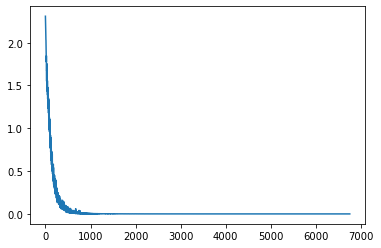

In [71]:
plt.figure()
plt.plot(loss_vec)
plt.show()

## MLP Evaluation

In [72]:
def evaluate(model):
#model = mlp
    predict_list = []
    correct = 0 
    for test_imgs, test_labels in test_loader:
        #print(test_imgs.shape)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        predict_list.append(predicted)
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct)*100 / (len(test_loader)*BATCH_SIZE)))
predict = evaluate(mlp)

Test accuracy:61.500% 


<center><h2>Convolutional Neural Network</h2></center>

## Explanation

To better understand convolutional neural network I recommend the great section on it here : http://cs231n.github.io/convolutional-networks/

**Convolutional operation** : First let's clarify briefly how we can perform the convolutional operation on an image. For that we need to define a **kernel** which is a small matrix of size 5 \* 5 for example. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image.

**Pooling** : the convolutional operation give an output of the same size of the input image. To reduce the size of the image and thus reduce the number of paramers in the model we perform a Pooling operation. The pooling operation need a window size.. By sliding the window along the image, we compute the mean or the max of the portion of the image inside the window in case of MeanPooling or MaxPooling.

**Stride** is the number of pixels to pass at a time when sliding the convolutional kernel.  

**Padding** to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image. 


**To remember** : What makes a CNN so interesting for images is that it is invariant by translation and for each convolutional layer we only need to store the kernels. Thus we can stack a lot of layers to learn deep features without having too much parameters that would make a model untrainnable. 

## Data loader

Since a CNN needs a image shape as input let's reshape our flatten images to real image

In [73]:
torch_X_train = torch_X_train.view(-1, 1,50,50).float()
torch_X_test = torch_X_test.view(-1,1,50,50).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


torch.Size([5376, 1, 50, 50])
torch.Size([1344, 1, 50, 50])


In [74]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(9*9*64,125)
        self.fc2 =nn.Linear(125,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,9*9*64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
 
cnn = CNN()
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(X_batch.shape)
print(cnn.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5184, out_features=125, bias=True)
  (fc2): Linear(in_features=125, out_features=10, bias=True)
)
torch.Size([200, 1, 50, 50])
torch.Size([200, 10])


In [75]:
fit(cnn,train_loader)

Epoch : 0 [0/5376 (0%)]	Loss: 2.300618	 Accuracy:11.000%
Epoch : 1 [0/5376 (0%)]	Loss: 2.141267	 Accuracy:24.000%
Epoch : 2 [0/5376 (0%)]	Loss: 1.844463	 Accuracy:37.000%
Epoch : 3 [0/5376 (0%)]	Loss: 1.667828	 Accuracy:45.500%
Epoch : 4 [0/5376 (0%)]	Loss: 1.402853	 Accuracy:53.000%
Epoch : 5 [0/5376 (0%)]	Loss: 1.285275	 Accuracy:56.500%


KeyboardInterrupt: 

In [ ]:
evaluate(cnn)

Test accuracy:10.071% 


In [ ]:
output = cnn.forward(X_batch)
predicted = torch.max(output.data,1)[1]
print(output)
print(X_batch.shape)
print(output.shape)
print(predicted.shape)
print(predicted)

tensor([[-2.2556, -2.3080, -2.3297,  ..., -2.3225, -2.3270, -2.3085],
        [-2.2557, -2.3084, -2.3296,  ..., -2.3227, -2.3274, -2.3082],
        [-2.2759, -2.3518, -2.3248,  ..., -2.3471, -2.3643, -2.2778],
        ...,
        [-2.2575, -2.3123, -2.3292,  ..., -2.3249, -2.3307, -2.3055],
        [-2.2759, -2.3518, -2.3248,  ..., -2.3471, -2.3643, -2.2778],
        [-2.2759, -2.3518, -2.3248,  ..., -2.3471, -2.3643, -2.2778]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([200, 1, 300, 300])
torch.Size([200, 10])
torch.Size([200])
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6

In [ ]:
predicted = torch.max(output.data,1)[1]
print(predicted)

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6])
